### Import the required packages

In [4]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib as plt
import json

%matplotlib inline

### Create the connection to the database

In [5]:
#Define the connection variables
host = 'production-bi-data-slave-1.psql.db.outfittery.de'
dbname = 'dwh'
user = 'ml'
pw = '<xBqWW1X~6dfwEh'


# Create the full connection string
conn_string = 'host=' + host + ' dbname=' + dbname + ' user=' + user + ' password=' + pw

# Print the connection string
print('Connecting to database\n{0}'.format(conn_string))

# Get the connection object
conn = psycopg2.connect(conn_string)

# Get the cursor object that we can run queries on
cursor = conn.cursor()
print('Connected!\n')

Connecting to database
host=production-bi-data-slave-1.psql.db.outfittery.de dbname=dwh user=ml password=<xBqWW1X~6dfwEh
Connected!



### Run the query to get the order & cm1 data in a pandas series

In [7]:
colnames = ['order_id', 'order_id_key', 'date_amount_paid', 'cm1', 'cm2', 'cm3', 'cm1_ratio', 'cm1_before_canc', 'cm1_before_canc_after_returns', 'cm1_before_canc_after_exp_returns']

my_query = "select " + ','.join(colnames) + " from ml.ecdc_alternative_cm_targets limit 10000"

# execute our Query
cursor.execute(my_query)
print('Executed Query')

# retrieve the records from the database

records = pd.DataFrame(cursor.fetchall(), columns = colnames)
records['cm1'] = records['cm1'].astype(float)
print('Retrieved Records')

Executed Query
Retrieved Records


In [8]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
order_id                             10000 non-null int64
order_id_key                         10000 non-null int64
date_amount_paid                     6684 non-null datetime64[ns]
cm1                                  10000 non-null float64
cm2                                  10000 non-null object
cm3                                  10000 non-null object
cm1_ratio                            10000 non-null object
cm1_before_canc                      10000 non-null object
cm1_before_canc_after_returns        10000 non-null object
cm1_before_canc_after_exp_returns    10000 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 546.9+ KB


### Plot the different metrics

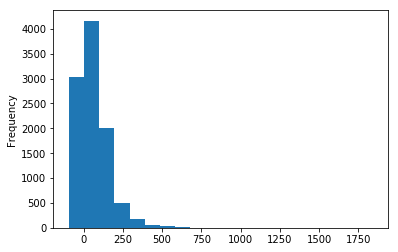

In [9]:
records['cm1'].plot.hist(bins = 20)

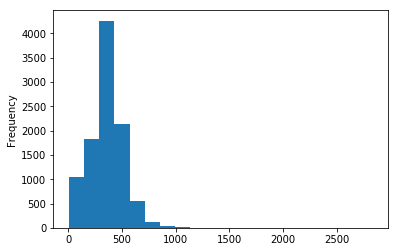

In [14]:
records['cm1_before_canc'].astype('float32').plot.hist(bins = 20)

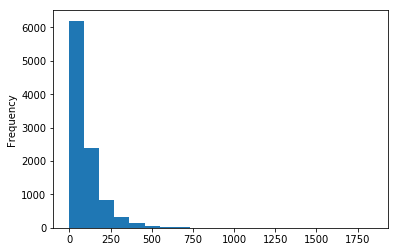

In [19]:
records['cm1_before_canc_after_returns'].astype('float32').plot.hist(bins = 20)

c:\users\conor\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


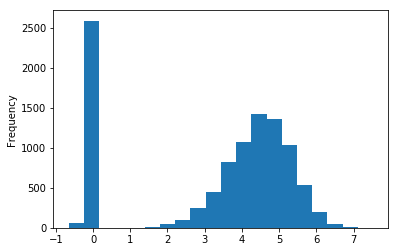

In [23]:
np.log(records['cm1_before_canc_after_returns'].astype('float32') + 1).plot.hist(bins = 20)

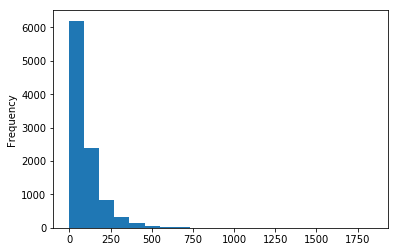

In [21]:
records['cm1_before_canc_after_exp_returns'].astype('float32').plot.hist(bins = 20)

### Create the error function

In [157]:
from sklearn.metrics.scorer import make_scorer
from scipy.stats import kendalltau

def kendall_rank_score(y, y_pred, X):
    '''
    Returns the Kendall rank coefficient for our data sorted by cm1 vs sorted by y_pred.
    See this link for more details:
    https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient
    
    @Paramaters:
    y: This is the 'ground truth' for the y values
        It's not used here as we are scoring based on rank rather than by comparing predicted values with their real ones
        It's required as a paramater by the make_scorer function from sklearn
        
    y_pred: our predicted y values
    
    X: The X values that were used to predict the y vector
    
    '''
    
    return kendalltau(X['cm1'], y_pred)[0]


def rank_weighted_mse(y, y_pred, X, cm_col = 'cm1'):
    '''
    Returns the Rank weighted MSE for our data sorted by cm1 vs sorted by y_pred.
    This is the MSE of CM1 weighted by (N-Rank)
    
    @Paramaters:
    y: This is the 'ground truth' for the y values
        It's not used here as we are scoring based on rank rather than by comparing predicted values with their real ones
        It's required as a paramater by the make_scorer function from sklearn
        
    y_pred: our predicted y values
    
    X: The X values that were used to predict the y vector
    
    '''

    
    base_cm1 = X[cm_col][np.argsort(X[cm_col])].reset_index(drop = True).astype('float')
    custom_rank_cm1 = X[cm_col][np.argsort(y_pred)].reset_index(drop = True).astype('float')
    
    
    numerator = 0.
    N = len(base_cm1)
    i = 0
    
    for base, custom in zip(base_cm1, custom_rank_cm1):
        i+=1
        numerator += (N-i)  * (base - custom) ** 2
        
    denominator = (N/2) * (N+1)
    
    mse = np.sqrt(numerator/denominator)
        
    
    return mse


#kendall_rank_scorer = make_scorer(kendall_rank_error, greater_is_better=True, X = X_test)
    

* Look at the base errors for the various different cm1 metrics

In [151]:
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
corrcols = ['cm2', 'cm3', 'cm1_ratio', 'cm1_before_canc', 'cm1_before_canc_after_returns', 'cm1_before_canc_after_exp_returns']

for col in corrcols:
    print('Pearson Correlation between cm1 & {0}: {1}'.format(col,pearsonr(records['cm1'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Spearman Correlation between cm1 & {0}: {1}'.format(col,spearmanr(records['cm1'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Kendall Correlation between cm1 & {0}: {1}'.format(col,kendalltau(records['cm1'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Rank weighted MSE between cm1 & {0}: {1}'.format(col,rank_weighted_mse(None, records[col].astype('float32'), records)))

#np.corrcoef(records.drop(['date_amount_paid'], inplace = False, axis = 1).head(10000).astype('float32'))

Pearson Correlation between cm1 & cm2: 0.986198902130127
Pearson Correlation between cm1 & cm3: 0.8264316320419312
Pearson Correlation between cm1 & cm1_ratio: 0.7697564363479614
Pearson Correlation between cm1 & cm1_before_canc: 0.384600430727005
Pearson Correlation between cm1 & cm1_before_canc_after_returns: 0.9055898785591125
Pearson Correlation between cm1 & cm1_before_canc_after_exp_returns: 0.9055898785591125


Spearman Correlation between cm1 & cm2: 0.9618826322014038
Spearman Correlation between cm1 & cm3: 0.7361639867599535
Spearman Correlation between cm1 & cm1_ratio: 0.9248901647510992
Spearman Correlation between cm1 & cm1_before_canc: 0.2521707467594222
Spearman Correlation between cm1 & cm1_before_canc_after_returns: 0.9247391748803571
Spearman Correlation between cm1 & cm1_before_canc_after_exp_returns: 0.9247391748803571


Kendall Correlation between cm1 & cm2: 0.8542953136700554
Kendall Correlation between cm1 & cm3: 0.571976260126073
Kendall Correlation between cm1 &

In [158]:
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
corrcols = ['cm1', 'cm3', 'cm1_ratio', 'cm1_before_canc', 'cm1_before_canc_after_returns', 'cm1_before_canc_after_exp_returns']

for col in corrcols:
    print('Pearson Correlation between cm2 & {0}: {1}'.format(col,pearsonr(records['cm2'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Spearman Correlation between cm2 & {0}: {1}'.format(col,spearmanr(records['cm2'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Kendall Correlation between cm2 & {0}: {1}'.format(col,kendalltau(records['cm2'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Rank weighted MSE between cm2 & {0}: {1}'.format(col,rank_weighted_mse(None, records[col].astype('float32'), records, 'cm2')))

#np.corrcoef(records.drop(['date_amount_paid'], inplace = False, axis = 1).head(10000).astype('float32'))

Pearson Correlation between cm2 & cm1: 0.986198902130127
Pearson Correlation between cm2 & cm3: 0.8617855310440063
Pearson Correlation between cm2 & cm1_ratio: 0.7838545441627502
Pearson Correlation between cm2 & cm1_before_canc: 0.3158695101737976
Pearson Correlation between cm2 & cm1_before_canc_after_returns: 0.885829746723175
Pearson Correlation between cm2 & cm1_before_canc_after_exp_returns: 0.885829746723175


Spearman Correlation between cm2 & cm1: 0.9618826322014039
Spearman Correlation between cm2 & cm3: 0.8047842280705798
Spearman Correlation between cm2 & cm1_ratio: 0.9140860387855723
Spearman Correlation between cm2 & cm1_before_canc: 0.1293020251545005
Spearman Correlation between cm2 & cm1_before_canc_after_returns: 0.8882186579017652
Spearman Correlation between cm2 & cm1_before_canc_after_exp_returns: 0.8882186579017652


Kendall Correlation between cm2 & cm1: 0.8542953136700554
Kendall Correlation between cm2 & cm3: 0.6501364675486065
Kendall Correlation between cm2 &

In [160]:
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
corrcols = ['cm1', 'cm2', 'cm1_ratio', 'cm1_before_canc', 'cm1_before_canc_after_returns', 'cm1_before_canc_after_exp_returns']

for col in corrcols:
    print('Pearson Correlation between cm3 & {0}: {1}'.format(col,pearsonr(records['cm3'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Spearman Correlation between cm3 & {0}: {1}'.format(col,spearmanr(records['cm3'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Kendall Correlation between cm3 & {0}: {1}'.format(col,kendalltau(records['cm3'].astype('float32'), records[col].astype('float32'))[0]))

print('\n')
for col in corrcols:
    print('Rank weighted MSE between cm3 & {0}: {1}'.format(col,rank_weighted_mse(None, records[col].astype('float32'), records, 'cm3')))

#np.corrcoef(records.drop(['date_amount_paid'], inplace = False, axis = 1).head(10000).astype('float32'))

Pearson Correlation between cm3 & cm1: 0.8264316320419312
Pearson Correlation between cm3 & cm2: 0.8617855310440063
Pearson Correlation between cm3 & cm1_ratio: 0.7114126682281494
Pearson Correlation between cm3 & cm1_before_canc: 0.13421662151813507
Pearson Correlation between cm3 & cm1_before_canc_after_returns: 0.7363534569740295
Pearson Correlation between cm3 & cm1_before_canc_after_exp_returns: 0.7363534569740295


Spearman Correlation between cm3 & cm1: 0.7361639867599535
Spearman Correlation between cm3 & cm2: 0.8047842280705797
Spearman Correlation between cm3 & cm1_ratio: 0.7577808240611353
Spearman Correlation between cm3 & cm1_before_canc: -0.04080584399528063
Spearman Correlation between cm3 & cm1_before_canc_after_returns: 0.6754070016665089
Spearman Correlation between cm3 & cm1_before_canc_after_exp_returns: 0.6754070016665089


Kendall Correlation between cm3 & cm1: 0.571976260126073
Kendall Correlation between cm3 & cm2: 0.6501364675486067
Kendall Correlation between 